In [1]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from datetime import datetime
from tabulate import tabulate
import numpy as np

In [2]:
seed = 256
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

1. Load, analyse and preprocess the CIFAR-10 dataset. Split it into 3 datasets: training, validation and test.
Take a subset of these datasets by keeping only 2 labels: bird and plane.

In [3]:
def load_cifar2():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    label_map = {0: 0, 2: 1}

    cifar2_train = [(img, label_map[label]) for img, label in cifar10_train if label in [0, 2]]
    cifar2_test = [(img, label_map[label]) for img, label in cifar10_test if label in [0, 2]]

    return cifar2_train, cifar2_test

In [4]:
cifar2_train, cifar2_test = load_cifar2()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
num_test_total = len(cifar2_test)
num_test = int(0.5 * num_test_total)
num_val = num_test_total - num_test

cifar2_test, cifar2_val = random_split(cifar2_test, [num_test, num_val])

In [6]:
print("Train Size:", len(cifar2_train))
print("Validation Size:", len(cifar2_val))
print("Test Size:", len(cifar2_test))

Train Size: 10000
Validation Size: 1000
Test Size: 1000


In [7]:
for name, dataset in zip(['Train', 'Validation', 'Test'], [cifar2_train, cifar2_val, cifar2_test]):
    counts = [sum(label == i for _, label in dataset) for i in range(2)]
    print(f"{name}: {counts[0]} Airplanes, {counts[1]} Birds")

Train: 5000 Airplanes, 5000 Birds
Validation: 516 Airplanes, 484 Birds
Test: 484 Airplanes, 516 Birds


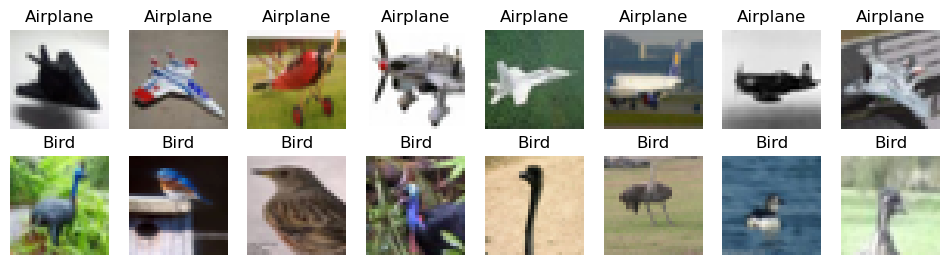

In [8]:
def show_imgs(imgs, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3))

    for i, (img, title) in enumerate(zip(imgs, titles)):
        img = img / 2 + 0.5
        npimg = img.numpy()
        row = i // cols
        col = i % cols
        axes[row, col].imshow(np.transpose(npimg, (1, 2, 0)))
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

    plt.show()


airplane_indices = [i for i, (img, label) in enumerate(cifar2_train) if label == 0][:8]
bird_indices = [i for i, (img, label) in enumerate(cifar2_train) if label == 1][:8]

airplane_images = [cifar2_train[i][0] for i in airplane_indices]
bird_images = [cifar2_train[i][0] for i in bird_indices]

show_imgs(airplane_images + bird_images, ['Airplane'] * 8 + ['Bird'] * 8, rows=2, cols=8)

In [9]:
def set_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device {device}.")
    return device


device = set_device()

Training on device cuda.


2. Write a `MyMLP` class that implements a MLP in PyTorch (so only fully connected layers) such that:
(a) The input dimension is 3072 (= 32 $\times$ 32 $\times$ 3) and the output dimension is 2 (for the 2 classes).
(b) The hidden layers have respectively 512, 128 and 32 hidden units.
(c) All activation functions are `ReLU`. The last layer has no activation function since the
cross-entropy loss already includes a softmax activation function.

In [10]:
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.flatten(x, 1)  # transforming into 1-dim vector 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

3. Write a `train(n_epochs, optimizer, model, loss_fn, train_loader)` function that trains model for `n_epochs`
epochs given an optimizer `optimizer`, a loss function `loss_fn` and a dataloader `train_loader`.

In [11]:
batch_size = 256

train_loader = DataLoader(cifar2_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(cifar2_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(cifar2_test, batch_size=batch_size, shuffle=False)

In [12]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    print(" --------- Using Pytorch's SGD ---------")

    train_losses = []
    for epoch in range(1, n_epochs + 1):
        epoch_loss = 0
        # loop over batches
        for imgs, labels in train_loader:
            # retrieve inputs and labels for this batch
            imgs, labels = imgs.to(device=device, dtype=torch.double), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if epoch == 1 or epoch % 5 == 0:
            timestamp = datetime.now().strftime('%H:%M:%S.%f')
            avg_loss = epoch_loss / len(train_loader)
            print(f"{timestamp}  |  Epoch {epoch}  |  Training loss {round(avg_loss, 5)}")

        train_losses.append(epoch_loss / len(train_loader))

    return train_losses

4. Write a similar function `train_manual_update` that has no `optimizer` parameter, but a learning rate `lr` parameter instead and that manually updates each trainable parameter of `model` using equation (2). Do not forget to zero out all gradients after each iteration.
6. Modify `train_manual_update` by adding a L2 regularization term in your manual parameter update. Add an additional weight decay parameter to `train_manual_update`. Compare again `train` and `train_manual_update` results with 0 < `weight_decay` < 1.
7. Modify `train_manual_update` by adding a momentum term in your parameter update. Add an additional `momentum` parameter to `train_manual_update`. Check again the correctness of the new update rule by comparing it to train function (with 0 < `momentum` < 1).


[SGD PyTorch Pseudocode](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [13]:
def evaluate_accuracy(model, loader):
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            # retrieve inputs and labels for this batch
            imgs, labels = imgs.to(device=device, dtype=torch.double), labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(imgs)

            # class with the highest value is what we choose as prediction
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [14]:
def train_manual_update(n_epochs, lr, model, loss_fn, train_loader, val_loader, weight_decay, momentum):
    print(" --------- Using manual update ----------")

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    momentum_buffers = {name: torch.zeros_like(p.data) for name, p in model.named_parameters()}

    for epoch in range(1, n_epochs + 1):
        train_epoch_loss = 0
        model.train()
        # loop over batches
        for imgs, labels in train_loader:
            # retrieve inputs and labels for this batch
            imgs, labels = imgs.to(device=device, dtype=torch.double), labels.to(device)

            # forward + backward
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()

            # manual parameter update using the gradient descent rule
            with torch.no_grad():
                for name, p in model.named_parameters():
                    grad = p.grad

                    # L2 regularization: adjust the gradient by adding weight_decay (L2 penalty) 
                    # times the parameters from the previous time step
                    grad += weight_decay * p.data

                    # compute the new buffer (accumulation of the gradient over time, scaled by 
                    # the momentum) using the previous buffer and the current gradient
                    buf = momentum_buffers[name]
                    buf.mul_(momentum).add_(grad)
                    grad = buf

                    # update the parameters, using the adjusted gradient and the learning rate lr
                    p.data -= lr * grad

            model.zero_grad()

            train_epoch_loss += loss.item()

        if epoch == 1 or epoch % 5 == 0:
            timestamp = datetime.now().strftime('%H:%M:%S.%f')
            avg_train_loss = train_epoch_loss / len(train_loader)
            print(f"{timestamp}  |  Epoch {epoch}  |  Training loss {round(avg_train_loss, 5)}")

        train_losses.append(train_epoch_loss / len(train_loader))

        # evaluation loop for validation loss
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device=device, dtype=torch.double), labels.to(device)
                outputs = model(imgs)
                val_loss = loss_fn(outputs, labels)
                val_epoch_loss += val_loss.item()

        avg_val_loss = val_epoch_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        train_accuracy = evaluate_accuracy(model, train_loader)
        val_accuracy = evaluate_accuracy(model, val_loader)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    return train_losses, val_losses, train_accuracies, val_accuracies

In [15]:
n_epochs = 30
l_rate = [0.01] * 6
momentum = [0, 0, 0.9, 0.9, 0.9, 0.8]
weight_decay = [0, 0.01, 0, 0.01, 0.001, 0.01]

hyperparameters = [(lr, mom, decay) for lr, mom, decay in zip(l_rate, momentum, weight_decay)]

In [16]:
train_losses_over_epochs_model1 = []
train_accuracies_model1 = []
val_accuracies_model1 = []

val_losses_over_epochs_model2 = []
train_losses_over_epochs_model2 = []
train_accuracies_over_epochs_model2 = []
val_accuracies_over_epochs_model2 = []
train_accuracies_model2 = []
val_accuracies_model2 = []

In [17]:
device = set_device()

for lr, mom, decay in hyperparameters:
    print(" =========================================================")
    print(f"   Current parameters:\nlr = {lr}\nmom = {mom}\ndecay = {decay}\n")

    torch.manual_seed(seed)
    model1 = MyMLP().to(device)
    # construct SGD optimizer and initialize learning rate, momentum and weight decay
    optimizer = optim.SGD(model1.parameters(), lr=lr, momentum=mom, weight_decay=decay)
    loss_fn = nn.CrossEntropyLoss()

    train_losses1 = train(n_epochs, optimizer, model1, loss_fn, train_loader)
    train_accuracy_model1 = evaluate_accuracy(model1, train_loader)
    val_accuracy_model1 = evaluate_accuracy(model1, val_loader)

    train_losses_over_epochs_model1.append(train_losses1)
    train_accuracies_model1.append(train_accuracy_model1)
    val_accuracies_model1.append(val_accuracy_model1)

    print("\n --- Accuracies ---")
    print(f"Training\nAccuracy: {round(train_accuracy_model1, 2)}")
    print(f"Validation\nAccuracy: {round(val_accuracy_model1, 2)}\n")

    torch.manual_seed(seed)
    model2 = MyMLP().to(device)

    train_losses2, val_losses2, train_accs2, val_accs2 = train_manual_update(n_epochs, lr, model2, loss_fn,
                                                                             train_loader, val_loader, decay, mom)
    train_accuracy_model2 = evaluate_accuracy(model2, train_loader)
    val_accuracy_model2 = evaluate_accuracy(model2, val_loader)

    train_losses_over_epochs_model2.append(train_losses2)
    val_losses_over_epochs_model2.append(val_losses2)
    train_accuracies_over_epochs_model2.append(train_accs2)
    val_accuracies_over_epochs_model2.append(val_accs2)
    train_accuracies_model2.append(train_accuracy_model2)
    val_accuracies_model2.append(val_accuracy_model2)

    print("\n --- Accuracies ---")
    print(f"Training\nAccuracy: {round(train_accuracy_model2, 2)}")
    print(f"Validation\nAccuracy: {round(val_accuracy_model2, 2)}\n")

Training on device cuda.
   Current parameters:
lr = 0.01
mom = 0
decay = 0

 --------- Using Pytorch's SGD ---------


18:33:07.526587  |  Epoch 1  |  Training loss 0.69167
18:33:09.655040  |  Epoch 5  |  Training loss 0.63007
18:33:12.354136  |  Epoch 10  |  Training loss 0.52969
18:33:15.071117  |  Epoch 15  |  Training loss 0.48058
18:33:17.807563  |  Epoch 20  |  Training loss 0.45366
18:33:20.560748  |  Epoch 25  |  Training loss 0.42749
18:33:23.261298  |  Epoch 30  |  Training loss 0.40067

 --- Accuracies ---
Training
Accuracy: 0.83
Validation
Accuracy: 0.84

 --------- Using manual update ----------
18:33:24.163415  |  Epoch 1  |  Training loss 0.69167
18:33:27.863833  |  Epoch 5  |  Training loss 0.63007
18:33:32.398469  |  Epoch 10  |  Training loss 0.52969
18:33:36.903947  |  Epoch 15  |  Training loss 0.48058
18:33:41.411216  |  Epoch 20  |  Training loss 0.45366
18:33:45.909913  |  Epoch 25  |  Training loss 0.42749
18:33:50.413971  |  Epoch 30  |  Training loss 0.40067

 --- Accuracies ---
Training
Accuracy: 0.83
Validation
Accuracy: 0.84

   Current parameters:
lr = 0.01
mom = 0
decay =

8. Train different instances (at least 4) of the `MyMLP` model with different learning rate, momentum and weight decay values. For hyperparameters values, you can find inspiration in the gradient descent `output.txt` file. Note that having different results than in this file is totally normal (e.g. if you had a different dataset split policy than the one used to create this file). However, your `train_manual_update` and `train` functions should give exactly the same results (as we can observe in gradient descent `output.txt`.

In [18]:
accuracies = [train_accuracies_model1, train_accuracies_model2, val_accuracies_model1, val_accuracies_model2]
headers = ["Hyperparameters", "Train Acc Model 1", "Train Acc Model 2", "Val Acc Model 1", "Val Acc Model 2"]

print(tabulate(list(zip(hyperparameters, *accuracies)), headers=headers))

Hyperparameters       Train Acc Model 1    Train Acc Model 2    Val Acc Model 1    Val Acc Model 2
------------------  -------------------  -------------------  -----------------  -----------------
(0.01, 0, 0)                     0.8348               0.8348              0.845              0.845
(0.01, 0, 0.01)                  0.8276               0.8276              0.84               0.84
(0.01, 0.9, 0)                   0.9575               0.9575              0.852              0.852
(0.01, 0.9, 0.01)                0.9164               0.9164              0.869              0.869
(0.01, 0.9, 0.001)               0.9564               0.9564              0.862              0.862
(0.01, 0.8, 0.01)                0.9573               0.9573              0.853              0.853


9. Select the best model among those trained in the previous question based on their accuracy.

In [19]:
best_model_idx = val_accuracies_model1.index(max(val_accuracies_model1))

best_lr, best_mom, best_decay = hyperparameters[best_model_idx]
best_val_accuracy = val_accuracies_model1[best_model_idx]

print(f" --- Best Model ---")
print(f"Hyperparameters: lr={best_lr}, mom={best_mom}, decay={best_decay}")
print(f"Validation Accuracy: {best_val_accuracy}")

 --- Best Model ---
Hyperparameters: lr=0.01, mom=0.9, decay=0.01
Validation Accuracy: 0.869


10. Evaluate the best model and analyse its performance.

In [20]:
def compute_accuracy_and_get_labels(model, loader):
    correct, total = 0, 0
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            # retrieve inputs and labels for this batch
            imgs, labels = imgs.to(device=device, dtype=torch.double), labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(imgs)

            # class with the highest value is what we choose as prediction
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.append(labels)
            pred_labels.append(predicted)
    return correct / total, true_labels, pred_labels

In [21]:
torch.manual_seed(seed)
model = MyMLP().to(device)
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_mom, weight_decay=best_decay)
loss_fn = nn.CrossEntropyLoss()

best_train_losses, best_test_losses, best_train_accs, best_test_accs = train_manual_update(n_epochs, best_lr, model,
                                                                                           loss_fn, train_loader,
                                                                                           test_loader, best_decay,
                                                                                           best_mom)

# evaluate the best model on the test dataset
model.eval()
test_accuracy, y_true, y_pred = compute_accuracy_and_get_labels(model, test_loader)

print(f"\nBest model hyperparameters: lr={best_lr}, mom={best_mom}, decay={best_decay}")
print(f"Test accuracy for the best model: {test_accuracy}")

 --------- Using manual update ----------
18:37:33.878985  |  Epoch 1  |  Training loss 0.66305
18:37:37.481837  |  Epoch 5  |  Training loss 0.41933
18:37:42.002212  |  Epoch 10  |  Training loss 0.29325
18:37:46.522857  |  Epoch 15  |  Training loss 0.21065
18:37:51.044676  |  Epoch 20  |  Training loss 0.24225
18:37:55.579664  |  Epoch 25  |  Training loss 0.1466
18:38:00.118551  |  Epoch 30  |  Training loss 0.13678

Best model hyperparameters: lr=0.01, mom=0.9, decay=0.01
Test accuracy for the best model: 0.828


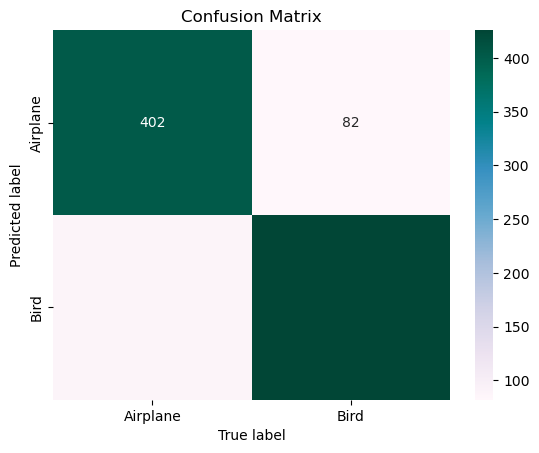

In [31]:
if device.type == 'cuda':
    cm = confusion_matrix(torch.cat(y_true).cpu(), torch.cat(y_pred).cpu())
    cm = confusion_matrix(torch.cat(y_true).cpu().numpy(), torch.cat(y_pred).cpu().numpy())
else:
    cm = confusion_matrix(torch.cat(y_true), torch.cat(y_pred))
sns.heatmap(cm, annot=True, fmt='g', cmap='PuBuGn',
            xticklabels=['Airplane', 'Bird'],
            yticklabels=['Airplane', 'Bird'])
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [37]:
if device.type == 'cuda':
    y_true_cpu = torch.cat(y_true).cpu().numpy() # Move to CPU and convert to numpy
    y_pred_cpu = torch.cat(y_pred).cpu().numpy() # Move to CPU and convert to numpy
    print(classification_report(y_true_cpu, y_pred_cpu, target_names=['Airplane', 'Bird']))
else:
    print(classification_report(torch.cat(y_true), torch.cat(y_pred), target_names=['Airplane', 'Bird']))

              precision    recall  f1-score   support

    Airplane       0.82      0.83      0.82       484
        Bird       0.84      0.83      0.83       516

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



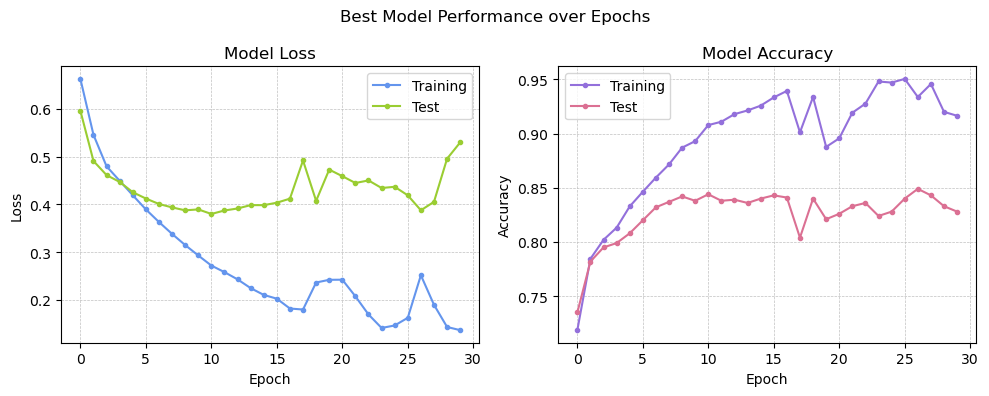

In [38]:
plt.figure(figsize=(10, 4))
plt.suptitle('Best Model Performance over Epochs')

plt.subplot(1, 2, 1)
plt.plot(best_train_losses, label='Training', color='cornflowerblue', marker='.')
plt.plot(best_test_losses, label='Test', color='yellowgreen', marker='.')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(color='silver', linestyle='--', linewidth=0.5)

plt.subplot(1, 2, 2)
plt.plot(best_train_accs, label='Training', color='mediumpurple', marker='.')
plt.plot(best_test_accs, label='Test', color='palevioletred', marker='.')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(color='silver', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

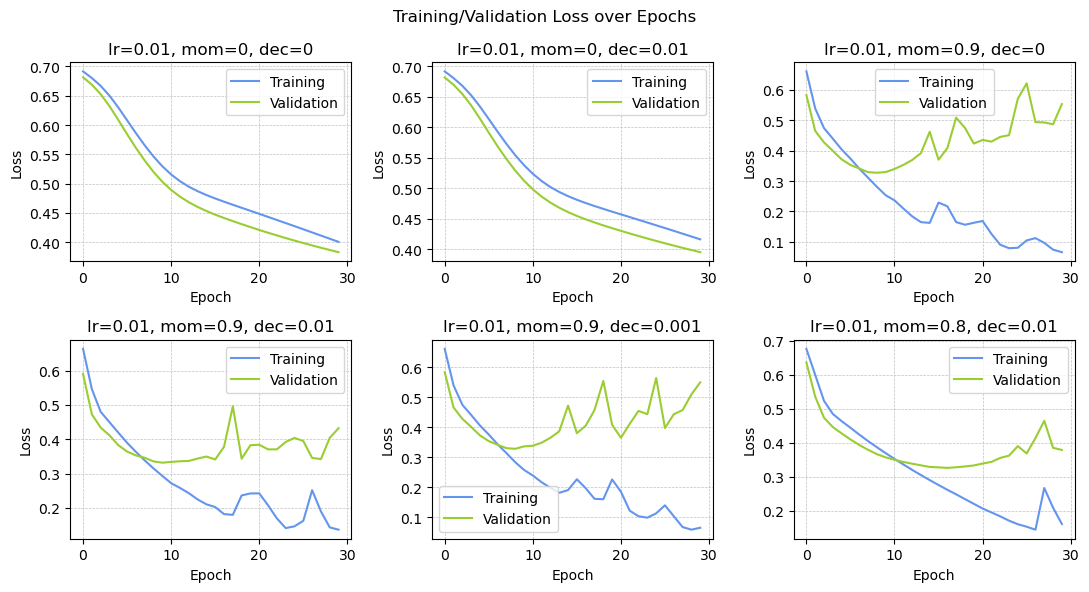

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6))

for i, (lr, mom, decay) in enumerate(hyperparameters):
    row = i // 3
    col = i % 3

    axes[row, col].plot(train_losses_over_epochs_model2[i], label='Training', color='cornflowerblue')
    axes[row, col].plot(val_losses_over_epochs_model2[i], label='Validation', color='yellowgreen')
    axes[row, col].set_title(f'lr={lr}, mom={mom}, dec={decay}')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Loss')
    axes[row, col].legend()
    axes[row, col].grid(color='silver', linestyle='--', linewidth=0.5)

plt.suptitle('Training/Validation Loss over Epochs')
plt.tight_layout()
plt.show()

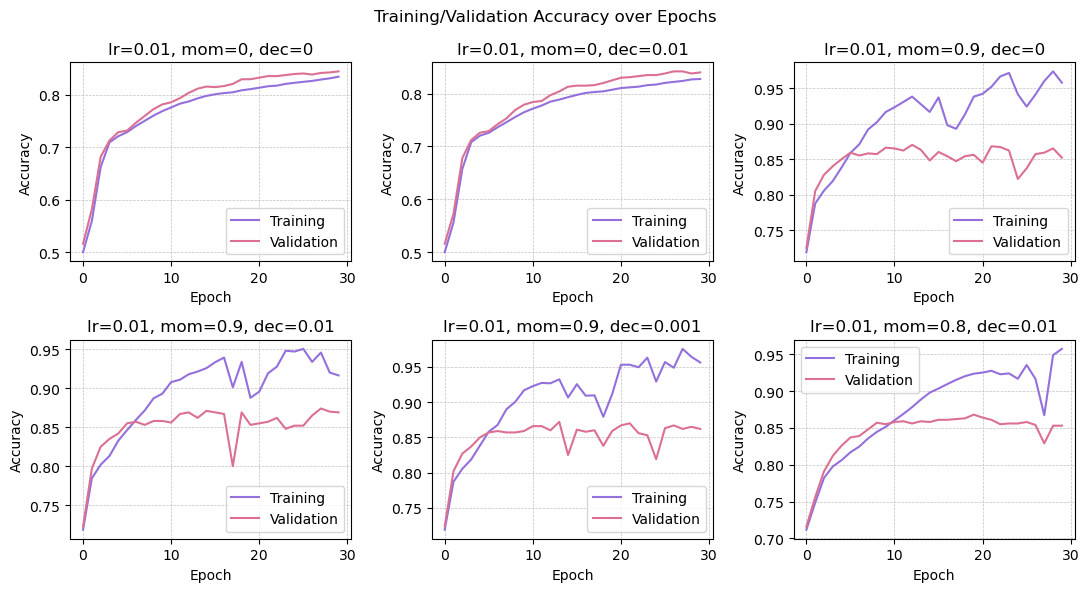

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6))

for i, (lr, mom, decay) in enumerate(hyperparameters):
    row = i // 3
    col = i % 3

    axes[row, col].plot(train_accuracies_over_epochs_model2[i], label='Training', color='mediumpurple')
    axes[row, col].plot(val_accuracies_over_epochs_model2[i], label='Validation', color='palevioletred')
    axes[row, col].set_title(f'lr={lr}, mom={mom}, dec={decay}')
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].legend()
    axes[row, col].grid(color='silver', linestyle='--', linewidth=0.5)

plt.suptitle('Training/Validation Accuracy over Epochs')
plt.tight_layout()
plt.show()